# Jan 31st, 2022 (seed filter)

**Motivation**: Why such large standard error for animals but not for the group?  Seed filtering should help. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_df_se(df, title=None, bbox_to_anchor=(1.07, 0.55)):
    fg = sns.catplot(
        data=df,
        x='oc_idx',
        y='SE',
        hue='label',
        col='bin_idx',
        col_wrap=2,
        kind='point',
        height=3.5,
        ci=None,
    )
    for ax in fg.axes.flat:
        ax.grid(ls=':')
        ax.set_title(ax.get_title(), fontsize=13)
        ax.set_xlabel(ax.xaxis.get_label().get_text(), fontsize=13)
        ax.set_ylabel(ax.yaxis.get_label().get_text(), fontsize=13)

    plt.setp(fg.legend, bbox_to_anchor=bbox_to_anchor)
    for text in fg.legend.get_texts():
        plt.setp(text, fontsize=14)
    fg.legend.set_title(title)
    plt.setp(fg.legend.get_title(), fontsize=15)
    plt.show()
    
    return fg

## Prepare

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [4]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group()
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

## Membership plot

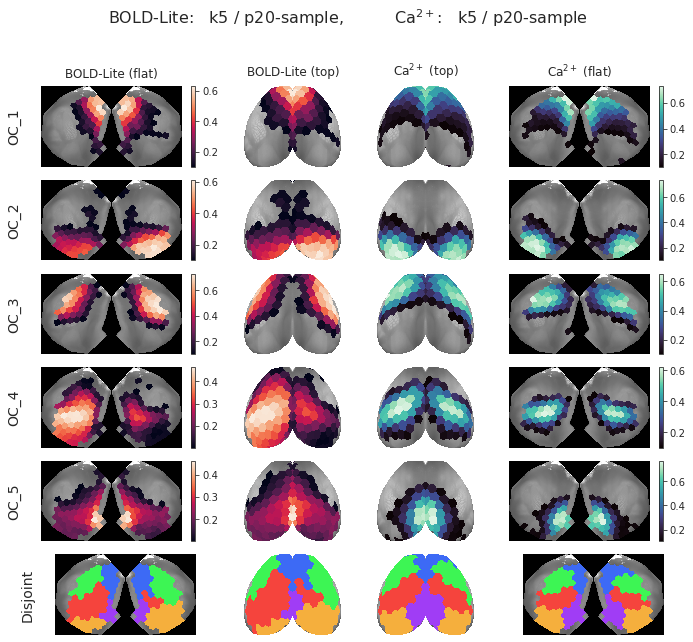

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [6]:
gr_bold.pi_symmetry_score(decimals=5)

(
    {1: 0.99193, 2: 0.98641, 3: 0.98106, 4: 0.94331, 5: 0.99653, -1: 0.97985},
    {1: 0.96552, 2: 0.82759, 3: 0.90805, 4: 0.71264, 5: 0.96552, -1: 0.87586}
)

In [7]:
gr_ca.pi_symmetry_score(decimals=5)

(
    {1: 0.98534, 2: 0.99246, 3: 0.9754, 4: 0.98806, 5: 0.99563, -1: 0.98738},
    {1: 0.95402, 2: 1.0, 3: 0.91954, 4: 0.95402, 5: 0.98851, -1: 0.96322}
)

## Filtered plot

In [8]:
gam_filt_bold = gr_bold.apply_seed_filt(1)
gam_filt_ca = gr_ca.apply_seed_filt(1)

pi_filt_bold = pi_from_gam(gam_filt_bold)
pi_filt_ca = pi_from_gam(gam_filt_ca)

pi_filt_bold = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_bold, 2), 1), 0)
pi_filt_ca = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_ca, 2), 1), 0)

In [9]:
gr_bold.pi_symmetry_score(pi_filt_bold, decimals=5)

(
    {1: 0.99189, 2: 0.98892, 3: 0.98121, 4: 0.94162, 5: 0.99508, -1: 0.97974},
    {1: 0.96552, 2: 0.95402, 3: 0.93103, 4: 0.89655, 5: 1.0, -1: 0.94943}
)

In [10]:
gr_ca.pi_symmetry_score(pi_filt_ca, decimals=5)

(
    {1: 0.98216, 2: 0.98924, 3: 0.96098, 4: 0.98932, 5: 0.99237, -1: 0.98281},
    {1: 0.94253, 2: 0.97701, 3: 0.90805, 4: 0.93103, 5: 0.98851, -1: 0.94943}
)

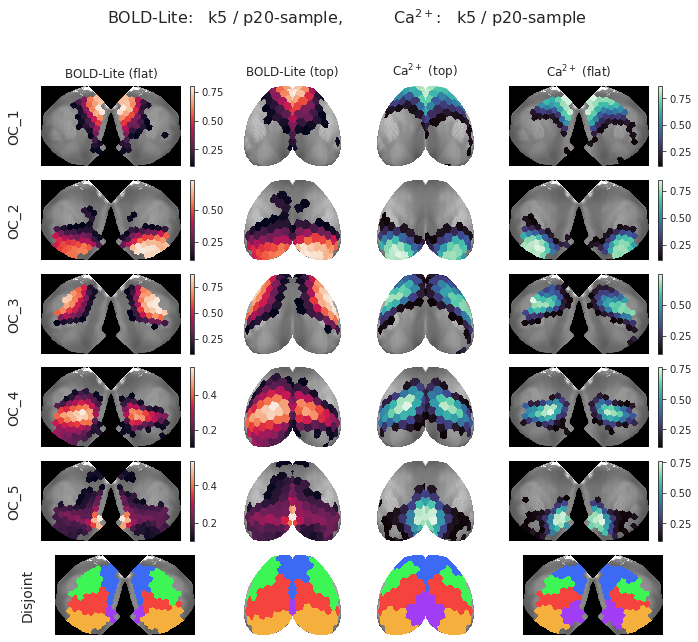

In [11]:
proj_bold = gr_bold.project_vec(pi_filt_bold)
proj_ca = gr_ca.project_vec(pi_filt_ca)

fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

## More K

  0%|          | 0/8 [00:00<?, ?it/s]

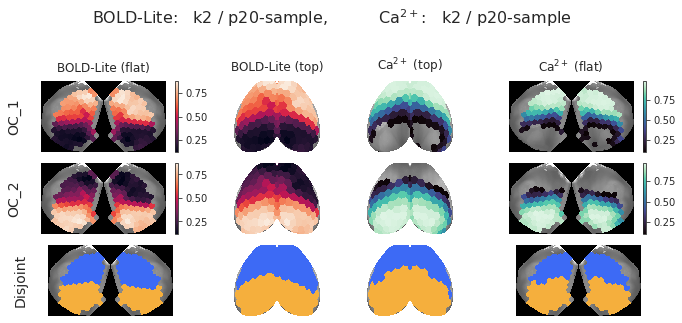

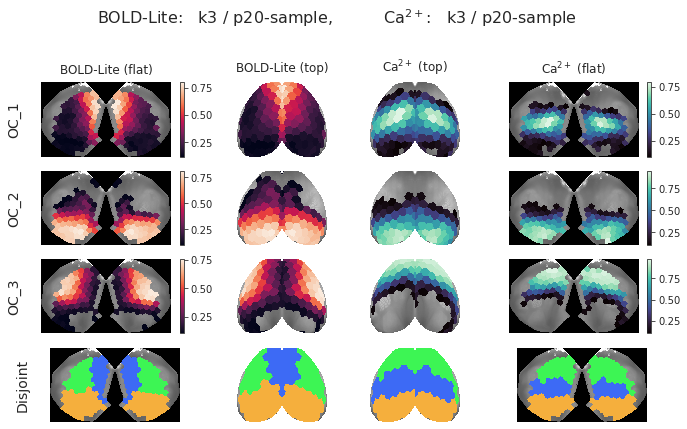

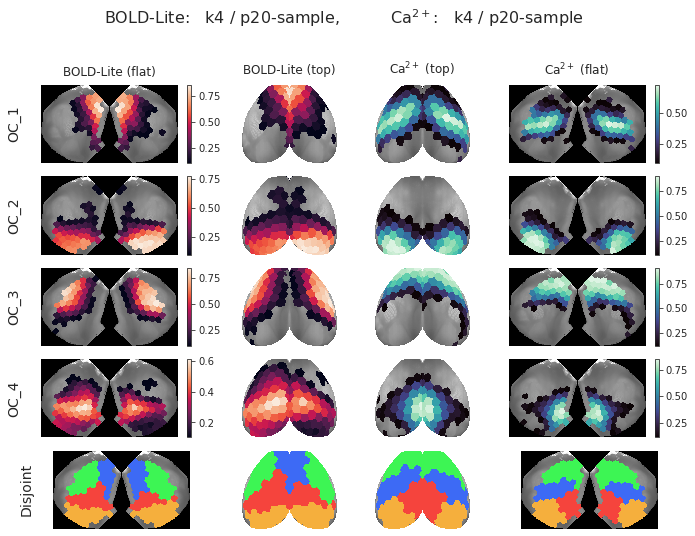

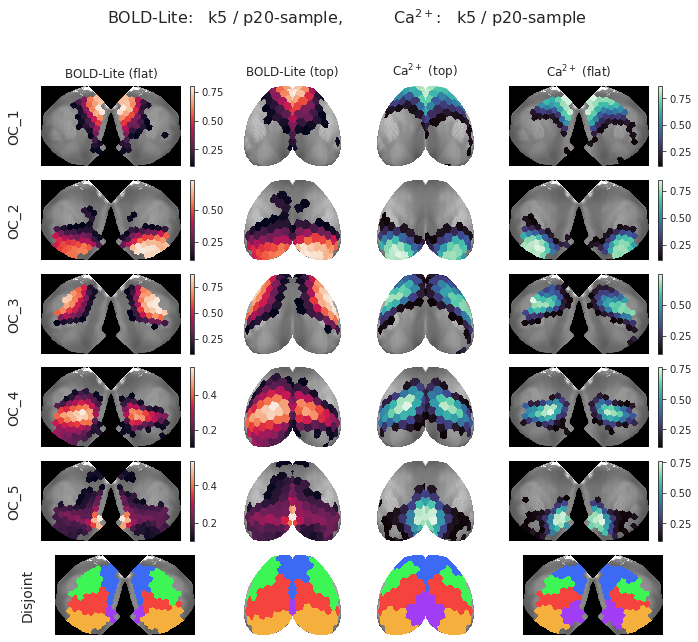

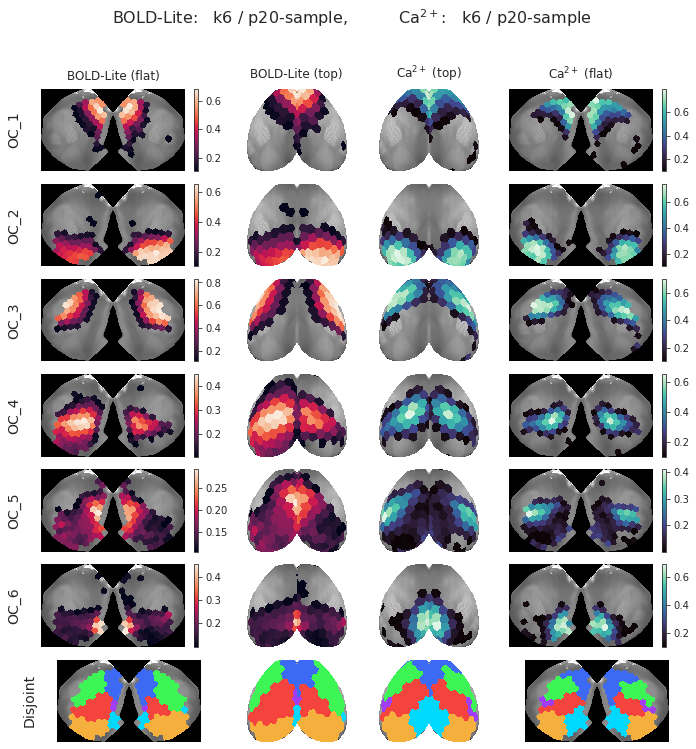

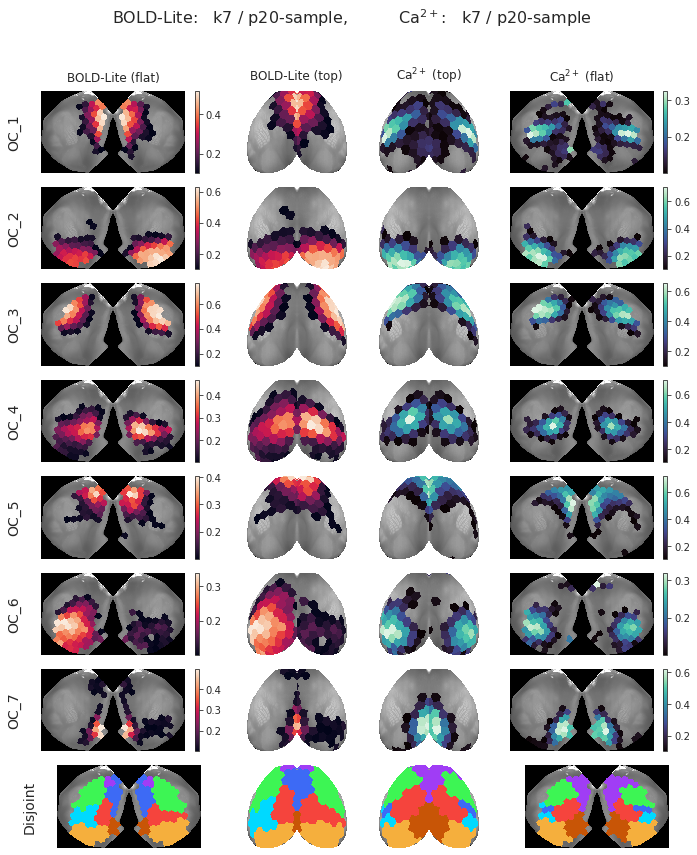

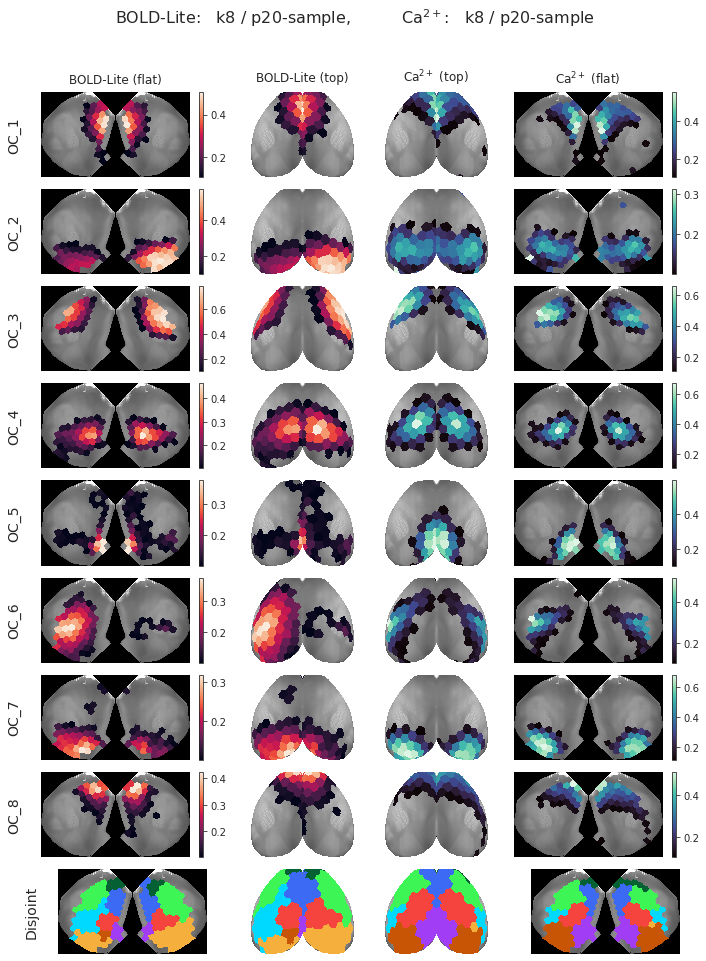

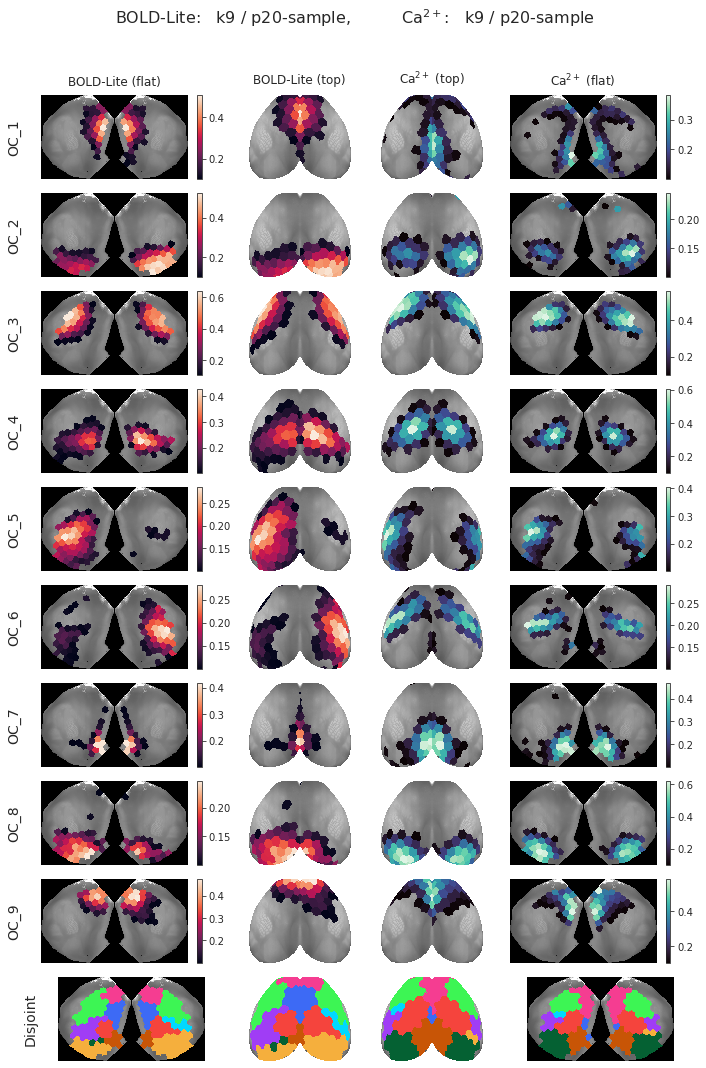

In [12]:
# HIDE CODE


for k in tqdm(range(2, 10)):
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p20-sample', **props}
    props_bold = {'perc': 'p20-sample', **props}

    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group()
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=_gr_bold.grp_pi,
        XB=_gr_ca.grp_pi,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())
    
    gam_filt_bold = _gr_bold.apply_seed_filt(1)
    gam_filt_ca = _gr_ca.apply_seed_filt(1)

    pi_filt_bold = pi_from_gam(gam_filt_bold)
    pi_filt_ca = pi_from_gam(gam_filt_ca)

    pi_filt_bold = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_bold, 2), 1), 0)
    pi_filt_ca = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_ca, 2), 1), 0)
    pi_filt_ca = pi_filt_ca[ids]

    _gr_bold.pi = pi_filt_bold
    _gr_ca.pi = pi_filt_ca

    proj_bold = _gr_bold.project_vec()
    proj_ca = _gr_ca.project_vec()

    fig, _ = _gr_ca.show(
        proj_bold, proj_ca,
        labels=('BOLD-Lite', r'Ca$^{2+}$'),
        cmaps=('rocket', 'mako'),
        display=False,
    )
    sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
    sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)

    display(fig)

In [13]:
# HIDE CODE


scores_cos, scores_ham = {}, {}
for k in range(2, 10):
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p20-sample', **props}
    props_bold = {'perc': 'p20-sample', **props}

    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group()
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group()
    
    gam_filt_bold = _gr_bold.apply_seed_filt(1)
    gam_filt_ca = _gr_ca.apply_seed_filt(1)

    pi_filt_bold = pi_from_gam(gam_filt_bold)
    pi_filt_ca = pi_from_gam(gam_filt_ca)

    pi_filt_bold = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_bold, 2), 1), 0)
    pi_filt_ca = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_ca, 2), 1), 0)

    sim = dist2sim(sp_dist.cdist(
        XA=pi_filt_bold,
        XB=pi_filt_ca,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())
    scores_cos[k] = sim[:, ids]

    _gr_bold.pi = pi_filt_bold
    _gr_ca.pi =  pi_filt_ca[ids]
    partition_bold = _gr_bold.get_disjoint_community(to_vec=True)
    partition_ca = _gr_ca.get_disjoint_community(to_vec=True)
    
    ham = np.zeros_like(sim)
    for i, j in itertools.combinations(range(1, 1 + k), 2):
        ham[i - 1, j - 1] = sp_dist.hamming(
            partition_bold == i, partition_ca == j)
    ham = ham + ham.T
    for i in range(1, 1 + k):
        ham[i - 1, i - 1] = sp_dist.hamming(
            partition_bold == i, partition_ca == i)
    scores_ham[k] = 1 - ham

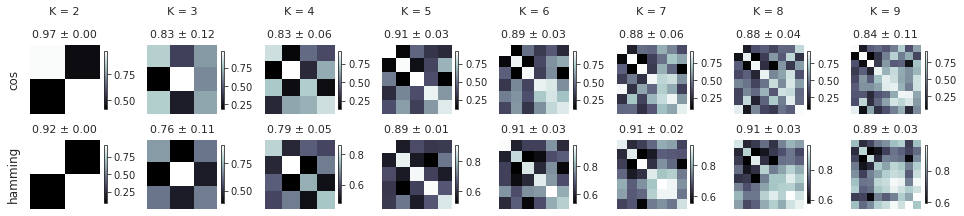

In [14]:
# HIDE CODE


fig, axes = create_figure(2, 8, (13.5, 3.2))

for i, (lbl, d) in enumerate({'cos': scores_cos, 'hamming': scores_ham}.items()):
    for ax, (k, s) in zip(axes[i].flat, d.items()):
        im = ax.imshow(s, cmap='bone')#, vmin=0, vmax=1)
        plt.colorbar(im, ax=ax, shrink=0.7)

        s_diag = np.diag(s)
        
        if i == 0:
            msg = f"K = {k}\n\n"
        else:
            msg = ''
        msg += f"{s_diag.mean():0.2f} ± {s_diag.std():0.2f}"
        ax.set_title(msg, fontsize=11, y=1.02)
        
        if k == list(scores_cos)[0]:
            ax.set_ylabel(lbl, fontsize=12, labelpad=10)
        # ax.invert_yaxis()
remove_ticks(axes)
plt.show()

In [15]:
# HIDE CODE


dlist = []
for k, cos in scores_cos.items():
    dlist.append({
        'k': [k] * k,
        'label': ['cos'] * k,
        'score': np.diag(cos),
        'oc_idx': range(1, 1 + k),
    })
    dlist.append({
        'k': [k] * k,
        'label': ['ham'] * k,
        'score': np.diag(scores_ham[k]),
        'oc_idx': range(1, 1 + k),
    })
df_compare = pd.DataFrame(merge_dicts(dlist))

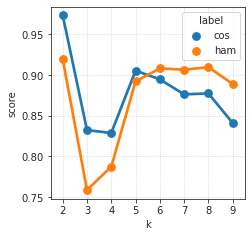

In [16]:
# HIDE CODE


fig, ax = create_figure(figsize=(3.6, 3.4))
sns.pointplot(
    data=df_compare,
    x='k',
    y='score',
    hue='label',
    ci=None,
    ax=ax,
)
ax.grid()

In [17]:
# HIDE CODE


dlist = []
num_top_seeds = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
    20, 25, 30, 35, 40, 50, 70, 100,
    150, 200, 250, 300, 350, 400, 450,
    500, 550, 600, 650, 700, 750, 800,
]
for k in range(2, 10):
    props = props_base.copy()
    props['num_k'] = k

    props_ca = {'perc': 'p20-sample', **props}
    props_bold = {'perc': 'p20-sample', **props}

    # Group results
    _gr_ca = Group(
        mode='ca2',
        centroids_from='runs',
        **props_ca,
    ).fit_group()
    _gr_bold = Group(
        mode='bold-lite',
        centroids_from='runs',
        **props_bold,
    ).fit_group()
    
    for n_top in num_top_seeds:
        if n_top > min(
            _gr_ca.run_top_seeds.shape[-1],
            _gr_bold.run_top_seeds.shape[-1]):
            continue

        gam_filt_bold = _gr_bold.apply_seed_filt(n_top)
        gam_filt_ca = _gr_ca.apply_seed_filt(n_top)

        pi_filt_bold = pi_from_gam(gam_filt_bold)
        pi_filt_ca = pi_from_gam(gam_filt_ca)

        pi_filt_bold = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_bold, 2), 1), 0)
        pi_filt_ca = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_ca, 2), 1), 0)
        
        cos = dist2sim(sp_dist.cdist(
            XA=pi_filt_bold,
            XB=pi_filt_ca,
            metric='cosine',
        ))
        mapping = find_best_match(cos)
        ids = list(mapping.values())
        
        _gr_bold.pi = pi_filt_bold
        _gr_ca.pi =  pi_filt_ca[ids]

        sym_ovp, sym_disj = _gr_bold.pi_symmetry_score()
        dlist.append({
            'k': [k] * len(sym_ovp),
            'n_seeds': [n_top] * len(sym_ovp),
            'label': ['sym_ovp_bold'] * len(sym_ovp),
            'oc_idx': sym_ovp.keys(),
            'score': sym_ovp.values(),
        })
        dlist.append({
            'k': [k] * len(sym_disj),
            'n_seeds': [n_top] * len(sym_disj),
            'label': ['sym_disj_bold'] * len(sym_disj),
            'oc_idx': sym_disj.keys(),
            'score': sym_disj.values(),
        })
        
        sym_ovp, sym_disj = _gr_ca.pi_symmetry_score()
        dlist.append({
            'k': [k] * len(sym_ovp),
            'n_seeds': [n_top] * len(sym_ovp),
            'label': ['sym_ovp_ca'] * len(sym_ovp),
            'oc_idx': sym_ovp.keys(),
            'score': sym_ovp.values(),
        })
        dlist.append({
            'k': [k] * len(sym_disj),
            'n_seeds': [n_top] * len(sym_disj),
            'label': ['sym_disj_ca'] * len(sym_disj),
            'oc_idx': sym_disj.keys(),
            'score': sym_disj.values(),
        })
        
        
        cos = cos[:, ids]
        cos = {
            i + 1: np.diag(cos)[i]
            for i in range(k)
        }
        cos = {**cos, -1: np.mean(list(cos.values()))}
        
        dlist.append({
            'k': [k] * len(cos),
            'n_seeds': [n_top] * len(cos),
            'label': ['cos'] * len(cos),
            'oc_idx': cos.keys(),
            'score': cos.values(),
        })

        _gr_bold.pi = pi_filt_bold
        _gr_ca.pi =  pi_filt_ca[ids]
        partition_bold = _gr_bold.get_disjoint_community(to_vec=True)
        partition_ca = _gr_ca.get_disjoint_community(to_vec=True)

        ham = np.zeros((k, k))
        for i, j in itertools.combinations(range(1, 1 + k), 2):
            ham[i - 1, j - 1] = sp_dist.hamming(
                partition_bold == i, partition_ca == j)
        ham = ham + ham.T
        for i in range(1, 1 + k):
            ham[i - 1, i - 1] = sp_dist.hamming(
                partition_bold == i, partition_ca == i)
        ham = 1 - ham
        ham = {
            i + 1: np.diag(ham)[i]
            for i in range(k)
        }
        ham = {**ham, -1: np.mean(list(ham.values()))}

        dlist.append({
            'k': [k] * len(ham),
            'n_seeds': [n_top] * len(ham),
            'label': ['ham'] * len(ham),
            'oc_idx': ham.keys(),
            'score': ham.values(),
        })
        
df_score = pd.DataFrame(merge_dicts(dlist))

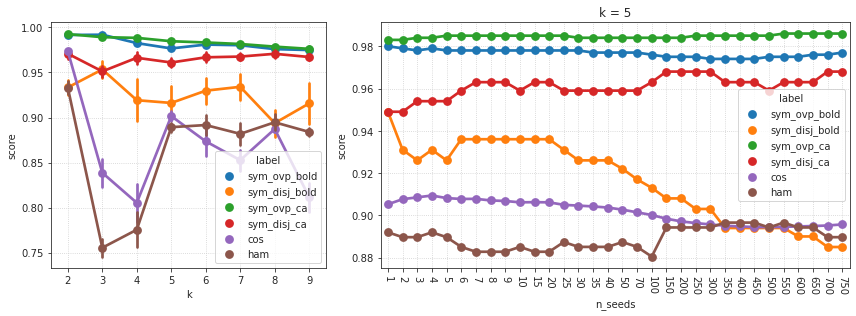

In [18]:
fig, axes = create_figure(1, 2, figsize=(12, 4.5), width_ratios=[1, 1.7])
_df = df_score.loc[df_score['oc_idx'] == -1]

sns.pointplot(
    data=_df,
    x='k',
    y='score',
    hue='label',
    ci='sd',
    ax=axes[0],
)
sns.pointplot(
    data=_df.loc[_df['k'] == 5],
    x='n_seeds',
    y='score',
    hue='label',
    ci='sd',
    ax=axes[1],
)
axes[1].tick_params(axis='x', rotation=-90)
axes[1].set_title('k = 5')

add_grid(axes)
plt.show()

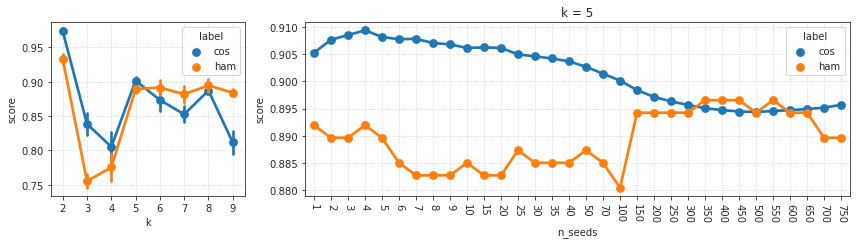

In [19]:
fig, axes = create_figure(1, 2, figsize=(12, 3.5), width_ratios=[1, 2.8])
_df = df_score.loc[
    (df_score['oc_idx'] == -1) &
    (df_score['label'].isin(['cos', 'ham']))
]

sns.pointplot(
    data=_df,
    x='k',
    y='score',
    hue='label',
    ci='sd',
    ax=axes[0],
)
sns.pointplot(
    data=_df.loc[_df['k'] == 5],
    x='n_seeds',
    y='score',
    hue='label',
    ci='sd',
    ax=axes[1],
)
axes[1].tick_params(axis='x', rotation=-90)
axes[1].set_title('k = 5')

add_grid(axes)
plt.show()

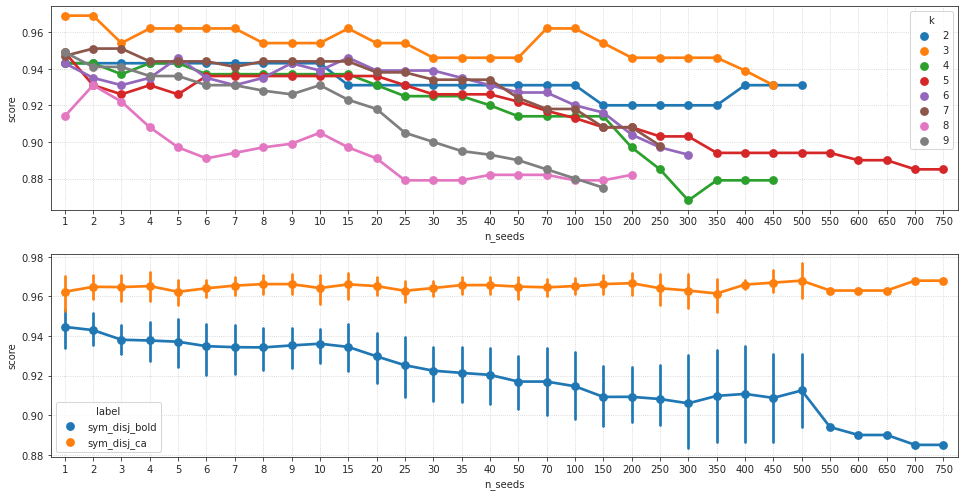

In [20]:
fig, axes = create_figure(2, 1, figsize=(13.5, 7))
_df = df_score.loc[
    (df_score['oc_idx'] == -1) &
    (df_score['label'] == 'sym_disj_bold')
]
sns.pointplot(
    data=_df,
    x='n_seeds',
    y='score',
    hue='k',
    ci='sd',
    ax=axes[0],
)
_df = df_score.loc[
    (df_score['oc_idx'] == -1) &
    (df_score['label'].isin(['sym_disj_bold', 'sym_disj_ca']))
]
sns.pointplot(
    data=_df,
    x='n_seeds',
    y='score',
    hue='label',
    ci=95,
    ax=axes[1],
)
add_grid(axes)
plt.show()

## Distributions

In [61]:
gam_filt_bold = gr_bold.apply_seed_filt(50)
gam_filt_ca = gr_ca.apply_seed_filt(50)

pi_filt_bold = pi_from_gam(gam_filt_bold, est_seed=None)
pi_filt_ca = pi_from_gam(gam_filt_ca, est_seed=None)

# pi_filt_bold = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_bold, 2), 1), 0)
# pi_filt_ca = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt_ca, 2), 1), 0)

In [62]:
pi_filt_bold.shape

(10, 3, 4, 50, 5, 174)

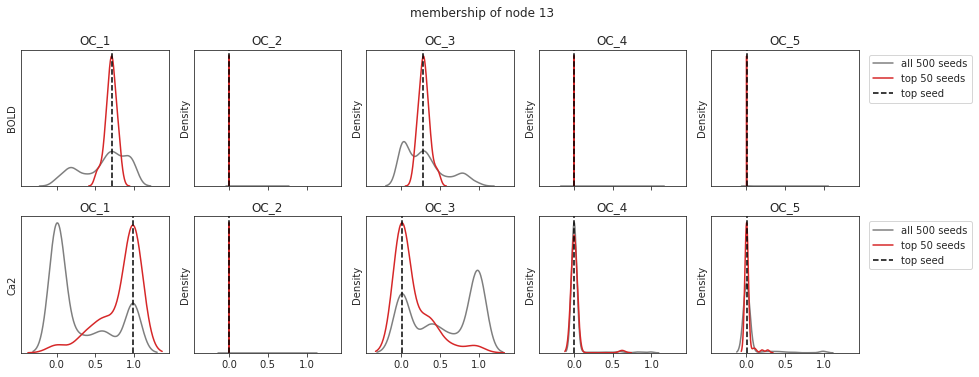

In [87]:
i, j, k = 3, 1, 2
nn = 13

data = {
    'BOLD': (pi_filt_bold, gr_bold.run_pi),
    'Ca2': (pi_filt_ca, gr_ca.run_pi),
}

fig, axes = create_figure(2, 5, (13.5, 5.3), 'all')
for ii, (lbl, (x, y)) in enumerate(data.items()):
    for kk in range(5):
        ax = axes[ii, kk]
        
        sns.kdeplot(
            y[i, j, k, :, kk, nn],
            color='C7',
            label='all 500 seeds',
            ax=ax,
        )
        sns.kdeplot(
            x[i, j, k, :, kk, nn],
            color='C3',
            label='top 50 seeds',
            ax=ax,
        )
        ax.axvline(
            x[i, j, k, 0, kk, nn],
            color='k',
            ls='--',
            label='top seed'
        )
        ax.set_title(f"OC_{kk+1}")
        ax.set_yticks([])
        if kk == 4:
            ax.legend()
        leg = ax.get_legend()
        if leg is not None:
            plt.setp(leg, bbox_to_anchor=(1.8, 1.0))
axes[0, 0].set_ylabel('BOLD')
axes[1, 0].set_ylabel('Ca2')
fig.suptitle('membership of node 13')
plt.show()

## Seed filter (draft)

In [88]:
data = gr_bold.run_gam[sub, ses, run]
nonan_seeds = np.where(np.isnan(data).sum(-1).sum(-1) == 0)[0]
data = data[nonan_seeds]

data_reshaped = data.reshape(-1, len(gr_bold.n2l))
nonan = np.where(np.isnan(data_reshaped).sum(0) == 0)[0]

data.shape, data_reshaped.shape, len(nonan)

((497, 5, 174), (2485, 174), 174)

In [91]:
centroids.shape

(5, 174)

In [120]:
centroids /= np.nansum(centroids, 0, keepdims=True)

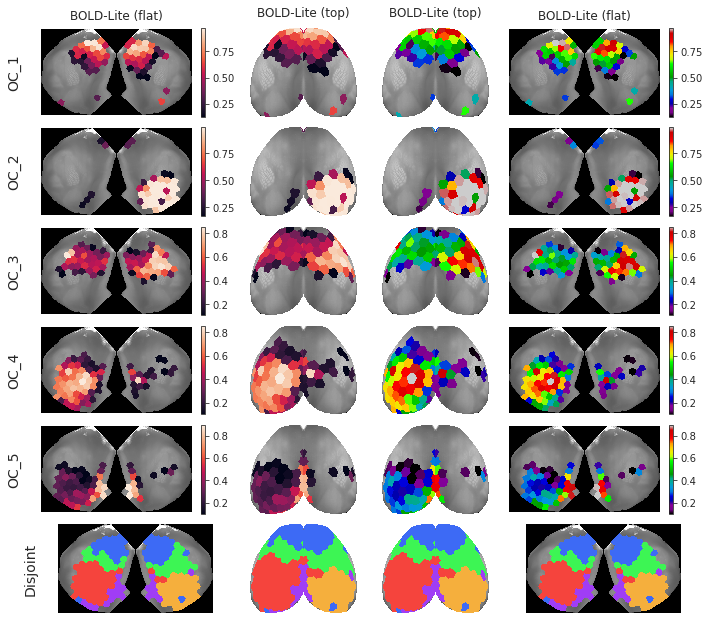

In [121]:
_ = gr_bold.show(gr_bold.project_vec(centroids))

In [93]:
centroids.shape

(5, 174)

In [94]:
dists_cos = np.zeros((len(nonan_seeds), gr_bold.num_k, gr_bold.num_k))
dists_cos_mean = np.zeros(len(nonan_seeds))

for seed_i in range(len(nonan_seeds)):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=data[seed_i][:, nonan],
        metric='cosine',
    )
    dists_cos[seed_i] = d
    dists_cos_mean[seed_i] = np.diag(d).mean()

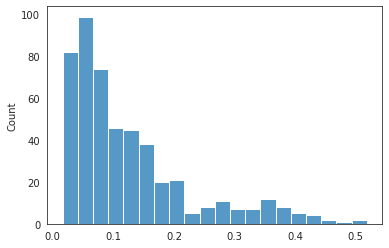

In [95]:
sns.histplot(dists_cos_mean);

In [110]:
top_n = 50
top_seeds = np.argsort(dists_cos_mean)[:top_n]

In [111]:
data[top_seeds].shape

(50, 5, 174)

<AxesSubplot:ylabel='Count'>

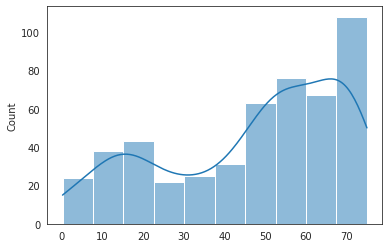

In [112]:
sns.histplot(gr_bold.run_gam[sub, ses, run, :, kk, nn], kde=True)

<AxesSubplot:ylabel='Count'>

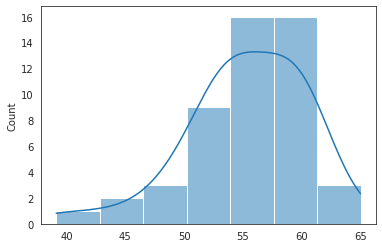

In [113]:
sns.histplot(data[top_seeds][:, kk, nn], kde=True)

In [116]:
xxx = data[top_seeds]
xxx /= np.nansum(xxx, -2, keepdims=True)
xxx = bn.nanmean(xxx, 0)
xxx.shape

(5, 174)

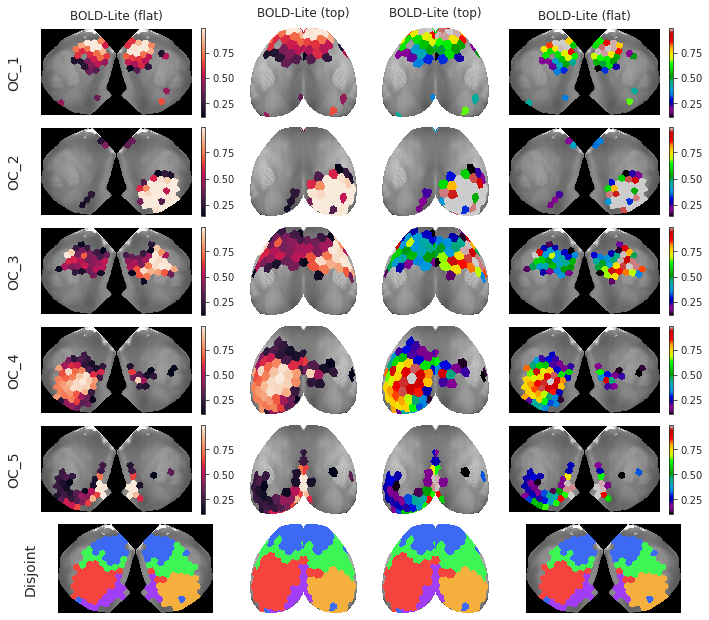

In [117]:
_ = gr_bold.show(gr_bold.project_vec(xxx))

In [ ]:
def 

### Filt all

In [191]:
gr_bold.run_gam.shape

(10, 3, 4, 500, 5, 174)

In [192]:
top_n = 100

shape = gr_bold.run_gam.shape
shape = list(shape)
shape[-3] = top_n
gam_filt = np_nans(shape)

gam_filt.shape

(10, 3, 4, 100, 5, 174)

In [225]:
self.run_gam.shape

(10, 3, 4, 500, 5, 174)

174

In [193]:
bad_runs = []
looper = itertools.product(range(10), range(3), range(4))

for i, j, k in tqdm(looper, total=120):
    data = gr_bold.run_gam[i, j, k]
    nan_seeds = np.where(np.isnan(data).sum(-1) == data.shape[-1])[0]
    good_seeds = np.delete(range(len(data)), nan_seeds)

    if not len(good_seeds):
        bad_runs.append((i, j, k))
        # print(f"bad run: (i, j, k) = ({i}, {j}, {k})")
        continue
    # print(i, j, k, len(good_seeds))

    data = data[good_seeds]
    data_flat = data.reshape(-1, data.shape[-1])
    nonan = np.where(np.isnan(data_flat).sum(0) == 0)[0]

    centroids = np_nans((gr_bold.num_k, data_flat.shape[-1]))
    _centroids, _ = fit_kmeans(
        data=data_flat[:, nonan],
        n_clusters=gr_bold.num_k,
        match_metric='euclidean',
        random_state=mice.cfg.random_state,
    )
    centroids[:, nonan] = _centroids

    global_mapping = gr_bold.align_centroid_to_structs(
        pi_mv=centroids,
        dist_metric=gr_bold.dist_metric,
        global_order=gr_bold.global_order,
    )
    centroids = centroids[global_mapping]
    
    dists_cos_mean = np.zeros(len(good_seeds))
    for seed_i in range(len(good_seeds)):
        d = sp_dist.cdist(
            XA=centroids[:, nonan],
            XB=data[seed_i][:, nonan],
            metric='cosine',
        )
        dists_cos_mean[seed_i] = np.diag(d).mean()

    top_seeds = np.argsort(dists_cos_mean)[:top_n]
    gam_filt[i, j, k] = data[top_seeds]

  0%|          | 0/120 [00:00<?, ?it/s]

In [194]:
gam_filt.shape

(10, 3, 4, 100, 5, 174)

In [222]:
pi_filt = pi_from_gam(gam_filt[..., range(100), :, :])
gr_bold.pi = bn.nanmean(bn.nanmean(bn.nanmean(pi_filt, 2), 1), 0)
proj = gr_bold.project_vec()

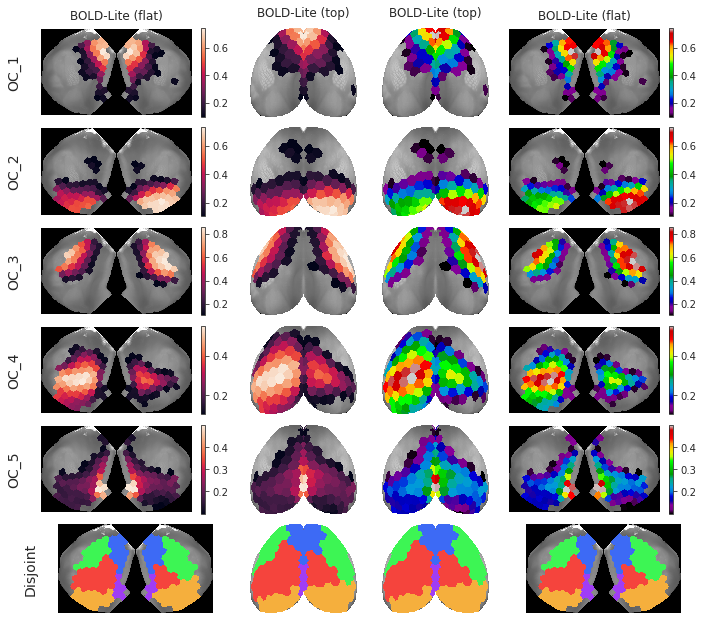

In [223]:
_ = gr_bold.show(proj)

In [224]:
pi_symmetry_score(gr_bold, decimals=3)

{1: 0.992, 2: 0.989, 3: 0.979, 4: 0.92, 5: 0.992, -1: 0.974}

{1: 0.992, 2: 0.989, 3: 0.979, 4: 0.922, 5: 0.993, -1: 0.975}